In [26]:
import pandas
import geopandas as gpd
import censusdata
import numpy as np

In [27]:
# Merging Water and Census Datasets
wdf_g = gpd.read_file('data/water_quality_clean.shp')
wdf_g.crs = "EPSG:4326"
wdf_g.rename(mapper={'avg_readin':'avg_reading', 
                     'max_readin':'max_reading',
                     'Threshold':'threshold'}, axis='columns', inplace=True)

# Downloading Census block boundaries for Chicago
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
census_group = census_gdf.dissolve(by='geo_12').reset_index()
census_group.crs = "EPSG:4326"

# Pulling ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B03002_002E': 'Not Hispanic'}

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))

# Rename columns 
acs_df.rename(columns=census_tables, inplace=True)
acs_df["geo_12"] = acs_df["GEO_ID"].map(lambda x: str(x)[-12:])
merged = census_group.merge(acs_df, on ="geo_12", how="inner")

# Creating new attributes
merged["p_white"] = (merged["White"]/merged["Race Total"])*100
merged["p_black"] = (merged["Black"]/merged["Race Total"])*100
merged["p_hispanic"] = ((merged['Race Total']-merged['Not Hispanic'])/merged["Race Total"])*100

merged.rename(mapper={'Median Income':'med_income'}, axis='columns', inplace=True)
merged["med_income"].replace({-666666666.0: merged["med_income"].median()}, inplace=True)

water_acs = gpd.sjoin(wdf_g, merged, how='inner', op='within')

In [28]:
avg_reading = water_acs.groupby('geo_12')['avg_reading'].mean().to_frame('avg_reading').reset_index()
max_reading = water_acs.groupby('geo_12')['max_reading'].mean().to_frame('max_reading').reset_index()
sample_cnt = water_acs.groupby('geo_12').size().to_frame('sample_cnt').reset_index()
for_plot = merged.merge(avg_reading, on="geo_12", how="outer")
for_plot = for_plot.merge(max_reading, on="geo_12", how="outer")
for_plot = for_plot.merge(sample_cnt, on="geo_12", how="outer")
for_plot['sample_cnt'] = for_plot['sample_cnt'].fillna(0)
for_plot['samp_density'] = for_plot['sample_cnt']/for_plot['Race Total']
for_plot['samp_density'] = for_plot['samp_density'].replace(np.infty, 0)
for_plot['samp_density'] = for_plot['samp_density'].fillna(0)

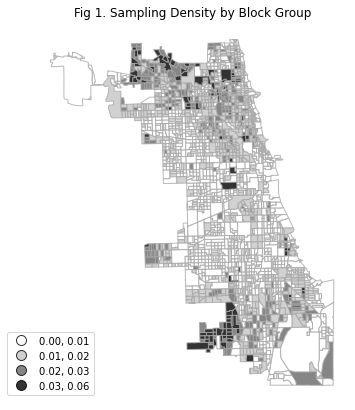

In [29]:
fig = for_plot.plot(column='samp_density',
                        cmap = 'Greys',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 1. Sampling Density by Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

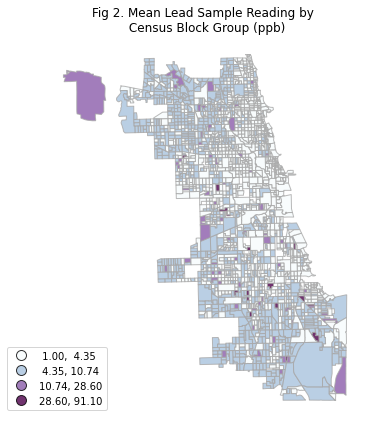

In [30]:
fig = for_plot.plot(column='max_reading',
                        cmap = 'BuPu',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 2. Mean Lead Sample Reading by \n Census Block Group (ppb)', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

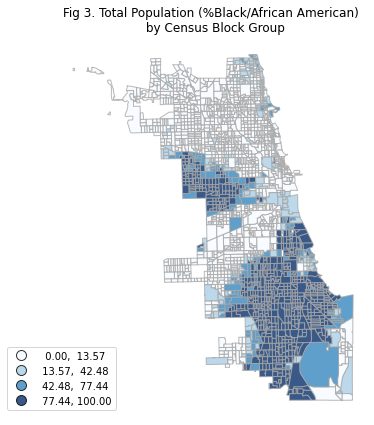

In [31]:
fig = for_plot.plot(column='p_black',
                        cmap = 'Blues',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 3. Total Population (%Black/African American) \n by Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

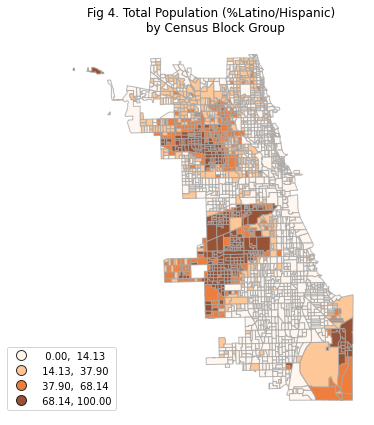

In [32]:
fig = for_plot.plot(column='p_hispanic',
                        cmap = 'Oranges',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 4. Total Population (%Latino/Hispanic) \n by Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

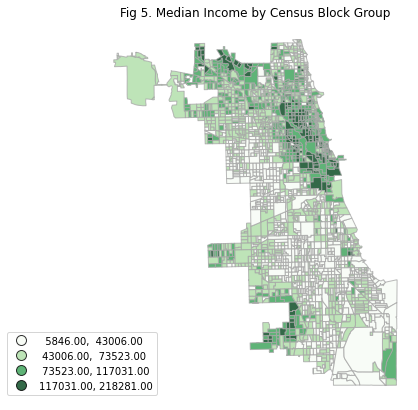

In [33]:
fig = for_plot.plot(column='med_income',
                        cmap = 'Greens',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 5. Median Income by Census Block Group', fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

The range for the water quality dataset is:
Max value: 730.0
Min value: 1.0


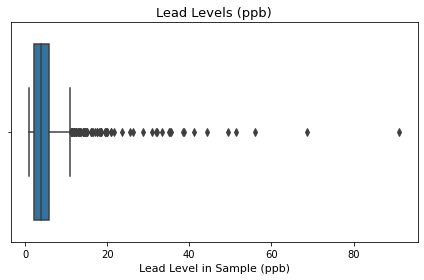

In [43]:
# Descriptive Statistics
import seaborn as sns
import matplotlib.pyplot as plt

print("The range for the water quality dataset is:")
print("Max value: {}\nMin value: {}".format(
    max(wdf_g['max_reading']), min(wdf_g['max_reading'])))

# Data is right-skewed
sampl_distrib = sns.boxplot(x="max_reading", data=for_plot)
plt.title('Fig X. Lead Levels (ppb)', fontsize=13) 
plt.xlabel('Lead Level in Sample (ppb)', fontsize=11)
plt.tight_layout()